In [3]:
import pandas as pd
from sklearn import preprocessing
import xgboost as xg
from sklearn import tree
from sklearn.model_selection import train_test_split
import graphviz 
import warnings
import numpy as np
import sqlite3
import json
from sklearn.metrics import roc_auc_score, roc_curve, log_loss, confusion_matrix, precision_score, recall_score, classification_report, accuracy_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
import joblib
from joblib import dump, load
%matplotlib inline


warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('csvs/encuestas.csv')

In [5]:
cand_data = json.loads(open('predictor_pol/candidatos.json','r').read())

In [6]:
def get_party(id):
    for p in cand_data:
        for c in p['candidates']:
            if c['id'] == id:
                return p['party']
    return 'n/a'

def get_name(id):
    for p in cand_data:
        for c in p['candidates']:
            if c['id'] == id:
                return c['name']
    return 'n/a'

In [7]:
df['partido'] = df.candidato.apply(get_party)
df['nombre'] = df.candidato.apply(get_name)

In [8]:
print("cantidad de registros: {}".format(len(df)))

cantidad de registros: 9025


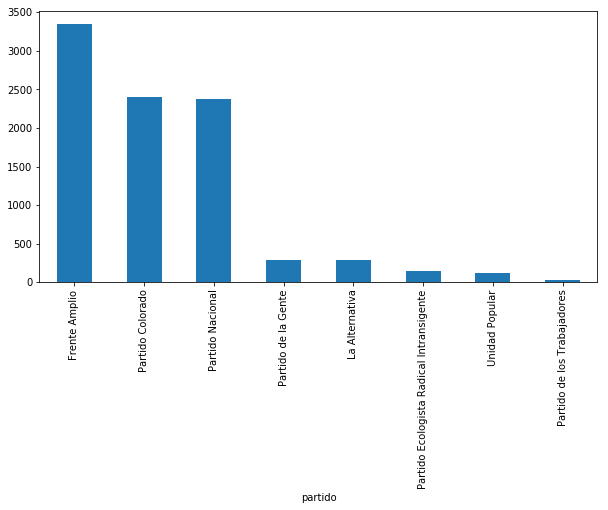

In [9]:
plt.rcParams['figure.figsize'] = [10, 5]
df.groupby('partido').size().sort_values(ascending=False).plot.bar()

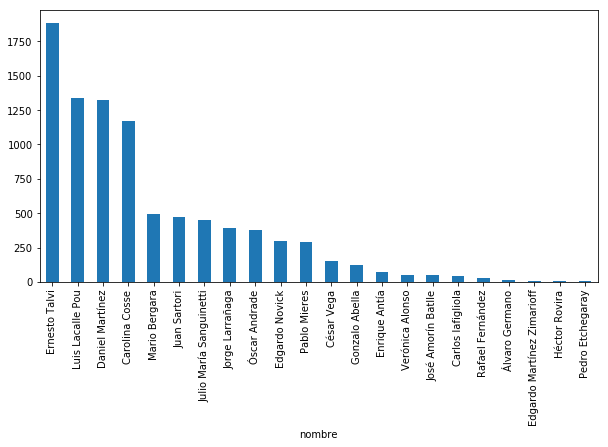

In [10]:
df.groupby('nombre').size().sort_values(ascending=False).plot.bar()

In [11]:
df4.head()

,id,candidato,fecha,partido,nombre
0,30,16,2019-02-03T16:13:13.649130,Partido Colorado,Julio María Sanguinetti
1,31,9,2019-02-04T22:14:04.368663,Partido Nacional,Luis Lacalle Pou
2,32,4,2019-02-05T13:03:33.624680,Frente Amplio,Daniel Martínez
3,33,19,2019-02-05T16:06:41.040221,Unidad Popular,Gonzalo Abella
4,34,18,2019-02-05T16:39:54.482634,La Alternativa,Pablo Mieres


In [12]:
respuestas = pd.read_csv('csvs/respuestas_encuestas.csv')

In [13]:
def resp(id_encuesta,id_pregunta):
    s= respuestas[(respuestas['id_encuesta'] == id_encuesta) & (respuestas['id_pregunta'] == id_pregunta)]['respuesta']
    return s.get_values()[0]

In [14]:
for i in range(1,27):
    df['resp_{}'.format(i)] = df.id.apply(lambda x: resp(x,i))

In [24]:
features = []
for i in range(1,27):
    features.append('resp_{}'.format(i))
df_train, df_test = train_test_split(df, test_size=0.20)
modelo_candidato = xg.XGBClassifier(n_estimators=500).fit(df_train[features], df_train.candidato)
df_test['candidato_predicho'] = modelo_candidato.predict(df_test[features])

ok = len(df_test[df_test.candidato_predicho == df_test.candidato])
precision = ok/len(df_test)
print("precision: {}".format(precision))

precision: 0.3667590027700831


In [16]:
df_test['nombre_predicho'] = df_test.candidato_predicho.apply(get_name)
df_test['partido_predicho'] = df_test.candidato_predicho.apply(get_party)
df_test[['candidato','candidato_predicho','nombre','partido','nombre_predicho','partido_predicho']].head()


,candidato,candidato_predicho,nombre,partido,nombre_predicho,partido_predicho
26,17,17,Ernesto Talvi,Partido Colorado,Ernesto Talvi,Partido Colorado
6453,3,4,Carolina Cosse,Frente Amplio,Daniel Martínez,Frente Amplio
1338,10,17,Jorge Larrañaga,Partido Nacional,Ernesto Talvi,Partido Colorado
94,17,17,Ernesto Talvi,Partido Colorado,Ernesto Talvi,Partido Colorado
3043,10,17,Jorge Larrañaga,Partido Nacional,Ernesto Talvi,Partido Colorado


# Ahora probamos KNeighborsClassifier

In [68]:
n=2
k=50

pca = PCA(n_components=n)
pca.fit(df[features])
X = pca.transform(df[features])
y = df.partido
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
candidate_model = KNeighborsClassifier(n_neighbors=n)
candidate_model.fit(X_train, y_train)
df_test['kn_candidate_prediction'] = candidate_model.predict(pca.transform(df_test[features]))

ok = len(df_test[df_test.kn_candidate_prediction == df_test.partido])
precision = ok/len(df_test)

print("precision partido: {}".format(precision))

precision partido: 0.7069252077562327


In [69]:
n=2
k=50

pca = PCA(n_components=n)
pca.fit(df[features])
X = pca.transform(df[features])
y = df.candidato
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
candidate_model = KNeighborsClassifier(n_neighbors=n)
candidate_model.fit(X_train, y_train)
df_test['kn_candidate_prediction'] = candidate_model.predict(pca.transform(df_test[features]))

ok = len(df_test[df_test.kn_candidate_prediction == df_test.candidato])
precision = ok/len(df_test)

print("precision candidato: {}".format(precision))

precision candidato: 0.5257617728531856


In [70]:
#exporto modelos
joblib.dump(pca,'predictor_pol/pca_2.joblib')
joblib.dump(candidate_model, 'predictor_pol/candidate_model_2.joblib')

['predictor_pol/candidate_model_2.joblib']

In [19]:

pcax = joblib.load('predictor_pol/pca.joblib')

d={'resp_21': ['1'], 'resp_1': ['1'], 
   'resp_23': ['1'], 'resp_24': ['1'], 'resp_11': ['1'], 
   'resp_9': ['1'], 'resp_13': ['1'], 'resp_14': ['1'], 
   'resp_10': ['1'], 'resp_22': ['1'], 'resp_5': ['1'], 'resp_16': ['1'], 
   'resp_3': ['1'], 'resp_18': ['1'], 'resp_2': ['1'], 'resp_8': ['1'], 
   'resp_12': ['1'], 'resp_19': ['1'], 'resp_17': ['1'], 'resp_26': ['1'], 
   'resp_20': ['1'], 'resp_4': ['1'], 'resp_25': ['1'], 'resp_15': ['1'], 'resp_6': ['1'], 'resp_7': ['1']}
foo = pd.DataFrame.from_dict(d)

In [20]:
bar = pcax.transform(foo)

In [21]:
bar#-5.5,4.68

array([[ 6.5448256 ,  5.72759799,  0.57375799,  3.90106416,  1.35008115,
        -1.19275233,  5.48938986,  2.04300234,  0.27126827,  1.9436323 ,
         0.84091097, -0.01458013, -0.0530169 ,  1.6270904 ,  1.84532615,
        -0.01694801, -0.51603911]])

In [22]:
candidate_model.predict(bar)#3


array([7])